In [1]:
import torch
import pickle
import random

In [2]:
import transformers

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [5]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [6]:
import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
def read_data(allowed_algorithms = ['azure','rekognition','detectron','google']):
    with open('multi_label_compiled_with_humans.p','rb') as F:
        multi_label_compiled_with_humans = pickle.load(F)
    print(multi_label_compiled_with_humans)
    human_data = []
    ai_data = []
    data_images = []
    for key in multi_label_compiled_with_humans.keys():
        data_images.append(key)
        data = multi_label_compiled_with_humans[key]
        human_data.append(' '.join(data['humans'][0]))
        
        for algo in allowed_algorithms:
            ai_data.append(' '.join(data[algo]))
    return human_data, ai_data, data_images

In [302]:
def embed_data(human_data, ai_data):
    ids = list(range(len(human_data)))
    cutoff_id = int(0.9*len(ids))
    random.shuffle(ids)
    sentences_train = {}
    sentences_val = {}
  

    for train_id in ids[:cutoff_id]:
        data = human_data[train_id]
        sentences_train[data] = 0
        ai_data_ = ai_data[train_id]
        if ai_data_ in sentences_val.keys():
            ai_data_ = 'NA'%ai_data_
        sentences_train[ai_data_] = 1
        
        
    print(len(sentences_val.keys()))
    for test_id in ids[cutoff_id:]:
        data = human_data[test_id]
        sentences_val[data] = 0
        ai_data_ = ai_data[test_id]
        if ai_data_ in sentences_val.keys():
            print(ai_data_)
            ai_data_ =  '%s_%s'%(ai_data_,test_id)
        sentences_val[ai_data_] = 1
    print(len(sentences_val.keys()))

        
    tokenized_train = tokenizer(list(sentences_train.keys()), padding = True, truncation = True, return_tensors="pt")
    tokenized_val = tokenizer(list(sentences_val.keys()) , padding = True, truncation = True,  return_tensors="pt")
    

    #move on device (GPU)
    tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
    tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}
    
    LE = LabelEncoder()
    labels_train = LE.fit_transform(list(sentences_train.values()))
    labels_val = LE.fit_transform(list(sentences_val.values()))
    
    with torch.no_grad():
        hidden_train = model(**tokenized_train) #dim : [batch_size(nr_sentences), tokens, emb_dim]
        hidden_val = model(**tokenized_val)

    #get only the [CLS] hidden states
    cls_train = hidden_train.last_hidden_state[:,0,:]
    cls_val = hidden_val.last_hidden_state[:,0,:]
    
    x_train = cls_train.to("cpu")
    y_train = labels_train

    x_val = cls_val.to("cpu")
    y_val = labels_val
    
    
    # Randomize test data
#     temp = list(zip(x_val, y_val))
#     random.shuffle(temp)
#     x_val, y_val = zip(*temp)
#     x_val, y_val = list(x_val), list(y_val)

#     y_val = np.array(y_val)
#     x_val = torch.vstack(x_val)
    
    return x_train, y_train, x_val, y_val, ids

In [303]:
def classify_and_score(algo = 'SVM'):
    if algo == 'RF':
        rf = RandomForestClassifier()
        rf.fit(x_train,y_train)
        predictions = rf.predict(x_val)
        score = rf.score(x_val,y_val) 
    elif algo == 'SVM':
        svm = SVC()
        svm.fit(x_train,y_train)
        predictions = svm.predict(x_val)
        score = svm.score(x_val,y_val) 
        
    conf_mat = confusion_matrix(y_val, predictions,normalize='true')
    return conf_mat, score, predictions

In [304]:
all_accuracies_M = {}

# All Combined

In [344]:
all_accuracies_M['all'] = {}

In [345]:
result_conf_mat = np.zeros((6,2))

In [346]:
human_data, ai_data,data_images = read_data()

In [347]:
ai_data_sampled = []
for i in range(0,len(ai_data),4):
    random_offset = random.choice([0,1,2,3])
    ai_data_sampled.append(ai_data[i+random_offset])

In [348]:
x_train,y_train,x_val,y_val,ids = embed_data(human_data, ai_data_sampled)

0
Person Human Clothing
Room Indoors Toilet
162


/tmp/ipykernel_30789/4140100945.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
/tmp/ipykernel_30789/4140100945.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}


In [349]:
svm_conf, svm_score,predictions = classify_and_score('SVM')

In [350]:
cutoff_id = int(0.9*len(ids))
test_images = []
for test_id in ids[cutoff_id:]:
    test_image = data_images[test_id]
    test_images.append(test_image)

In [351]:
for im_ct in range(len(test_images)):
    test_image = test_images[im_ct]
    pred_1 = predictions[im_ct]
    gt_1 = y_val[im_ct]
    
    pred_2 = predictions[im_ct + 81]
    gt_2 = y_val[im_ct + 81]
    all_accuracies_M['all'][test_image] = [pred_1 == gt_1]
    all_accuracies_M['all'][test_image].append(pred_2 == gt_2)

In [352]:
result_conf_mat[0] = svm_conf[0]
result_conf_mat[1] = svm_conf[1]

# Humans vs Azure

In [353]:
all_accuracies_M['azure'] = {}

In [355]:
human_data, ai_data,data_images = read_data(['azure'])
x_train,y_train,x_val,y_val,ids = embed_data(human_data, ai_data)
svm_conf, svm_score,predictions = classify_and_score('SVM')

0
animal mammal outdoor
person clothing human face
person outdoor clothing
162


/tmp/ipykernel_30789/4140100945.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
/tmp/ipykernel_30789/4140100945.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}


In [356]:
svm_score

0.9135802469135802

In [357]:
cutoff_id = int(0.9*len(ids))
test_images = []
for test_id in ids[cutoff_id:]:
    test_image = data_images[test_id]
    test_images.append(test_image)

for im_ct in range(len(test_images)):
    test_image = test_images[im_ct]
    pred_1 = predictions[im_ct]
    gt_1 = y_val[im_ct]
    
    pred_2 = predictions[im_ct + 81]
    gt_2 = y_val[im_ct + 81]
    all_accuracies_M['azure'][test_image] = [pred_1 == gt_1]
    all_accuracies_M['azure'][test_image].append(pred_2 == gt_2)

In [359]:
svm_score

0.9135802469135802

In [360]:
result_conf_mat[2] = svm_conf[1]

# Humans vs Detectron

In [361]:
all_accuracies_M['detectron'] = {}

In [362]:
human_data, ai_data,data_images = read_data(['detectron'])
x_train,y_train,x_val,y_val,ids = embed_data(human_data, ai_data)
svm_conf, svm_score,predictions = classify_and_score('SVM')
# print('RF accuracy:%s'%rf_score)
# print('RF confusion:%s'%rf_conf)

result_conf_mat[3] = svm_conf[1]

0
person kite
train
car bus person
zebra
162


/tmp/ipykernel_30789/4140100945.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
/tmp/ipykernel_30789/4140100945.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}


In [363]:
cutoff_id = int(0.9*len(ids))
test_images = []
for test_id in ids[cutoff_id:]:
    test_image = data_images[test_id]
    test_images.append(test_image)

for im_ct in range(len(test_images)):
    test_image = test_images[im_ct]
    pred_1 = predictions[im_ct]
    gt_1 = y_val[im_ct]
    
    pred_2 = predictions[im_ct + 81]
    gt_2 = y_val[im_ct + 81]
    all_accuracies_M['detectron'][test_image] = [pred_1 == gt_1]
    all_accuracies_M['detectron'][test_image].append(pred_2 == gt_2)

# Humans vs Google

In [366]:
all_accuracies_M['google'] = {}

In [364]:
human_data, ai_data, data_images = read_data(['google'])
x_train,y_train,x_val,y_val,ids = embed_data(human_data, ai_data)
svm_conf, svm_score,predictions = classify_and_score('SVM')
# print('RF accuracy:%s'%rf_score)
# print('RF confusion:%s'%rf_conf)

result_conf_mat[4] = svm_conf[1]

0
Food Tableware Plate
Food Ingredient Recipe
162


/tmp/ipykernel_30789/4140100945.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
/tmp/ipykernel_30789/4140100945.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}


In [367]:
cutoff_id = int(0.9*len(ids))
test_images = []
for test_id in ids[cutoff_id:]:
    test_image = data_images[test_id]
    test_images.append(test_image)

for im_ct in range(len(test_images)):
    test_image = test_images[im_ct]
    pred_1 = predictions[im_ct]
    gt_1 = y_val[im_ct]
    
    pred_2 = predictions[im_ct + 81]
    gt_2 = y_val[im_ct + 81]
    all_accuracies_M['google'][test_image] = [pred_1 == gt_1]
    all_accuracies_M['google'][test_image].append(pred_2 == gt_2)

# Humans vs Rekognition

In [368]:
all_accuracies_M['rekognition'] = {}all_accuracies_M

In [369]:
human_data, ai_data,data_images = read_data(['rekognition'])
x_train,y_train,x_val,y_val,ids = embed_data(human_data, ai_data)
svm_conf, svm_score,predictions = classify_and_score('SVM')
# print('RF accuracy:%s'%rf_score)
# print('RF confusion:%s'%rf_conf)

result_conf_mat[5] = svm_conf[1]

0
Person Human Tennis
Bus Vehicle Transportation
Person Human Skateboard
Person Human Tennis Racket
Person Human Skateboard
Person Human Skateboard
Person Human Truck
Plant Vegetable Food
Person Human Tennis
162


/tmp/ipykernel_30789/4140100945.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
/tmp/ipykernel_30789/4140100945.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}


In [370]:
cutoff_id = int(0.9*len(ids))
test_images = []
for test_id in ids[cutoff_id:]:
    test_image = data_images[test_id]
    test_images.append(test_image)

for im_ct in range(len(test_images)):
    test_image = test_images[im_ct]
    pred_1 = predictions[im_ct]
    gt_1 = y_val[im_ct]
    
    pred_2 = predictions[im_ct + 81]
    gt_2 = y_val[im_ct + 81]
    all_accuracies_M['rekognition'][test_image] = [pred_1 == gt_1]
    all_accuracies_M['rekognition'][test_image].append(pred_2 == gt_2)

In [ ]:
# import pickle
# with open('all_machine_data.p','wb') as F:
#     pickle.dump(all_accuracies_M,F)

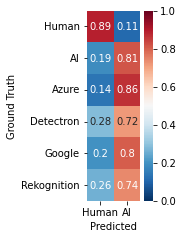

In [372]:
modelist = ['Azure','Detectron','Google','Rekognition']

plotname = 'mutli_label_recognition'

import os
os.makedirs('figures',exist_ok=True)

#plot confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(result_conf_mat, index = [i for i in ['Human','AI']+modelist],
                  columns = [i for i in ['Human','AI']])
plt.figure(figsize = (1.2,3.5))
sn.heatmap(df_cm, annot=True,robust=True, cmap='RdBu_r', vmin=0, vmax=1)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")

plt.savefig('figures/' + plotname + '_bert_confmat.pdf', bbox_inches='tight')
plt.show()

# STD calculation

In [391]:
def boostrap(data1, data2):
    import random
    import math
    store = []
    sample_mean = []
    if len(data1) < len(data2):
        SampleTimes = math.ceil(len(data1)/2)
        BootstrapTimes = len(data1)
    else:
        SampleTimes = math.ceil(len(data2)/2)
        BootstrapTimes = len(data2)
        
    #print(BootstrapTimes)        
    for i in range(BootstrapTimes):
        y1 = random.sample(data1, SampleTimes)
        #print(y1)
        y2 = random.sample(data2, SampleTimes)
        #print(y2)
        y_comb = y1+y2
        #print(y_comb)
        sample_mean.append(np.mean(np.array(y_comb), axis=0))
    
    stdval = np.std(np.array(sample_mean), axis=0)
    return stdval

In [392]:
all_stds = []
for split in ['all','azure','detectron','google','rekognition']:
    data_1 = []
    data_2 = []
    for im in all_accuracies_M[split].keys():
        if all_accuracies_M[split][im][0] == True:
            data_1.append(1)
        else:
            data_1.append(0)

        if all_accuracies_M[split][im][1] == True:
            data_2.append(1)
        else:
            data_2.append(0)
    stdval = boostrap(data_1,data_2)
    all_stds.append(stdval)

In [394]:
# all_stds

In [395]:
modelist

['Azure', 'Detectron', 'Google', 'Rekognition']

In [398]:
# plotname

No handles with labels found to put in legend.


[[0.88888889 0.11111111]
 [0.18518519 0.81481481]
 [0.13580247 0.86419753]
 [0.28395062 0.71604938]
 [0.19753086 0.80246914]
 [0.25925926 0.74074074]]
[0.8518518518518519, 0.8765432098765431, 0.8024691358024691, 0.845679012345679, 0.8148148148148148]


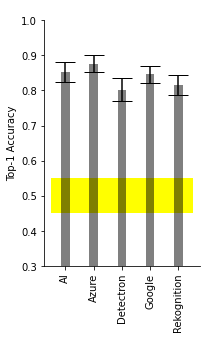

In [399]:
#compute top 1 accuracy for each AI model and also overall AI
top1 = []
print(result_conf_mat)
for i in range(1+len(modelist)):
    #print(i)
    top1.append((result_conf_mat[0][0]+result_conf_mat[i+1][1])/2)
print(top1)

import matplotlib.pyplot as plt
import numpy as np
 
#data
#x-axis
years = list(range(1, 2+len(modelist)))
strtask = ['AI'] + modelist
#print(years)
#print(strtask)

# Figure Size
fig, ax = plt.subplots()

from matplotlib.patches import Rectangle
ax.add_patch(Rectangle((-0.5, 0.45), len(top1), 0.1,facecolor='yellow'))

#bar chart properties
# ax.bar(strtask, top1, color ='black', width = 0.3)
ax.bar(strtask, top1, yerr=all_stds,
       align='center', alpha=0.5, ecolor='black', capsize=10,
       color ='black', width = 0.3)

plt.ylabel('Top-1 Accuracy')
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

plt.ylim(0.3, 1)
#plt.xlim(0.5, len(years)+0.5)

#draw chance 0.5 
# chancex =np.arange(len(years))
# plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
#plt.legend()
 
fig.tight_layout()

fig.set_figwidth(2.5)
fig.set_figheight(5)

fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()
fig.savefig('figures/' + plotname + '_bert.pdf', bbox_inches='tight')